## BIBLIOTHÈQUES ET CONSTANTES

In [24]:
%matplotlib inline
from keras.applications import vgg16
from keras.models import Model, Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing import image
from keras.optimizers import RMSprop
import numpy as np
from numpy.random import permutation
import bcolz
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt

In [25]:
DATA_PATH = "../data/statefarm/"
#DATA_PATH = "../data/statefarm/sample/"
MODELS_PATH = "../data/statefarm/models/"
RESULTS_PATH = %pwd
RESULTS_PATH = RESULTS_PATH+'/results/'
% pwd

'/home/pierre/state-farm'

## VISUALISATION DES DONNÉES

In [14]:
VIS_PATH = "../data/statefarm/sample/"

In [15]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [16]:
gen = image.ImageDataGenerator()
# model.predict a aussi besoin de données sous forme de numpy array.
batches = gen.flow_from_directory(VIS_PATH+'train', target_size=(224, 224), class_mode=None,
                                 shuffle=False, batch_size=1)
train_data = np.concatenate([batches.next() for i in range(batches.samples)])
filenames = batches.filenames

Found 500 images belonging to 10 classes.


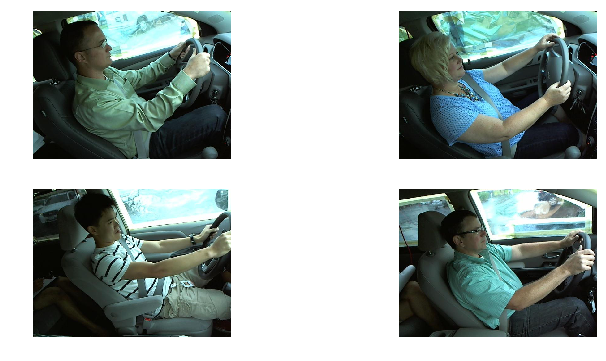

In [47]:
# CLASSE C0
idx = np.where(batches.classes==0)
plots([image.load_img(DATA_PATH+'train/'+filenames[i]) for i in idx[0][:4]], rows=2)

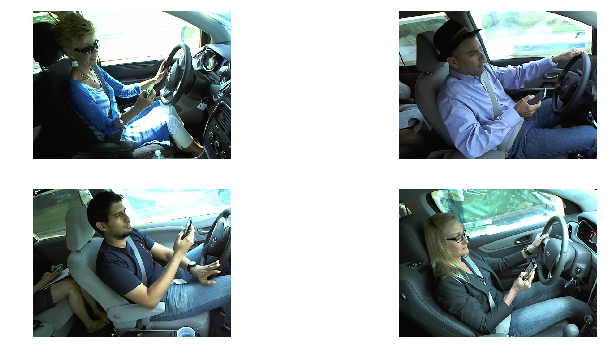

In [32]:
# CLASSE C1
idx = np.where(batches.classes==1)
plots([image.load_img(DATA_PATH+'train/'+filenames[i]) for i in idx[0][:4]], rows=2)

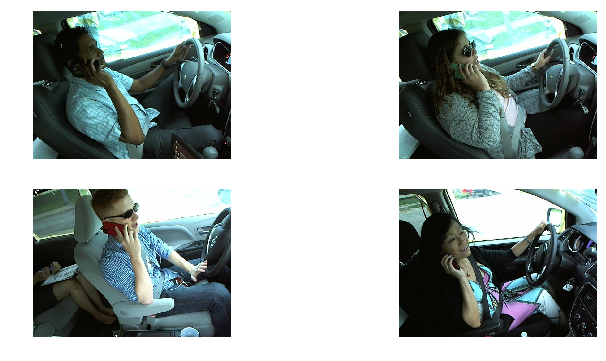

In [33]:
# CLASSE C2
idx = np.where(batches.classes==2)
plots([image.load_img(DATA_PATH+'train/'+filenames[i]) for i in idx[0][:4]], rows=2)

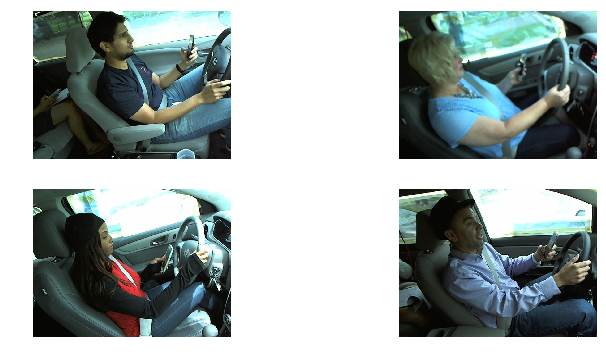

In [34]:
# CLASSE C3
idx = np.where(batches.classes==3)
plots([image.load_img(DATA_PATH+'train/'+filenames[i]) for i in idx[0][:4]], rows=2)

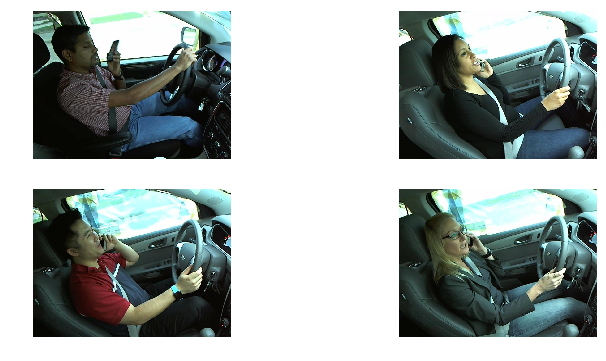

In [35]:
# CLASSE C4
idx = np.where(batches.classes==4)
plots([image.load_img(DATA_PATH+'train/'+filenames[i]) for i in idx[0][:4]], rows=2)

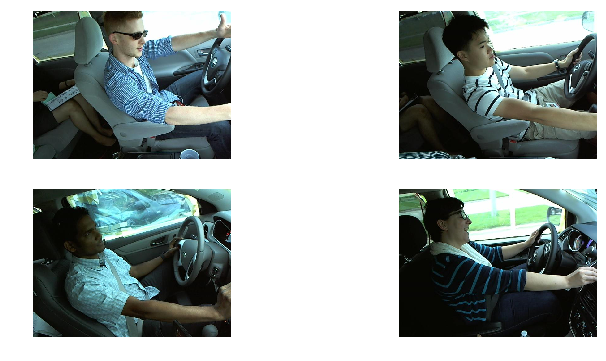

In [36]:
# CLASSE C5
idx = np.where(batches.classes==5)
plots([image.load_img(DATA_PATH+'train/'+filenames[i]) for i in idx[0][:4]], rows=2)

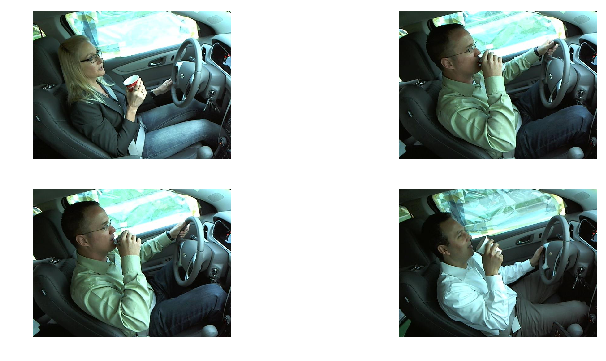

In [37]:
# CLASSE C6
idx = np.where(batches.classes==6)
plots([image.load_img(DATA_PATH+'train/'+filenames[i]) for i in idx[0][:4]], rows=2)

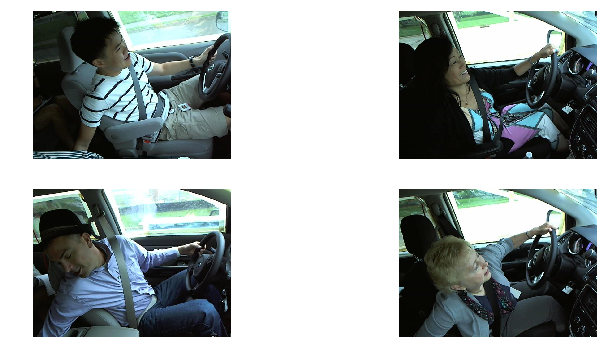

In [38]:
# CLASSE C7
idx = np.where(batches.classes==7)
plots([image.load_img(DATA_PATH+'train/'+filenames[i]) for i in idx[0][:4]], rows=2)

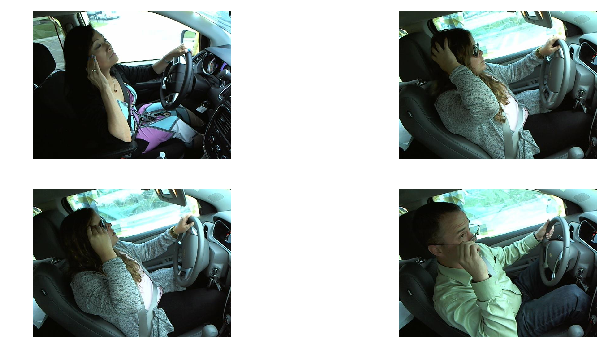

In [39]:
# CLASSE C8
idx = np.where(batches.classes==8)
plots([image.load_img(DATA_PATH+'train/'+filenames[i]) for i in idx[0][:4]], rows=2)

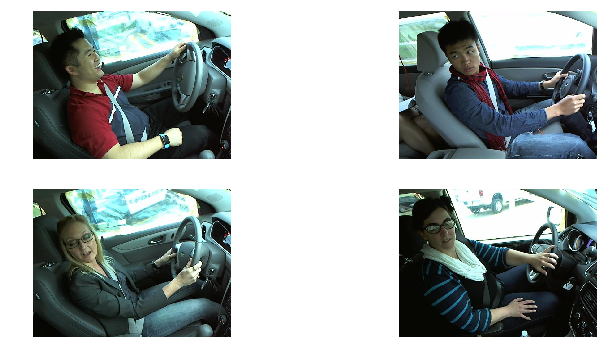

In [40]:
# CLASSE C9
idx = np.where(batches.classes==9)
plots([image.load_img(DATA_PATH+'train/'+filenames[i]) for i in idx[0][:4]], rows=2)

## RÉCUPÉRATION DU MODÈLE VGG16 SANS LES COUCHES DENSES

In [26]:
vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None,
                  input_shape=(224, 224, 3))

In [27]:
for layer in vgg.layers: layer.trainable=False

In [28]:
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## FINETUNING

### Création du modèle de finetuning

In [29]:
x = vgg.output

In [30]:
x = Flatten(input_shape=vgg.output_shape[1:])(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

### Fusion avec le réseau de convolution VGG16

In [31]:
model = Model(inputs=vgg.input, outputs=predictions)

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [33]:
opt = RMSprop(lr=0.00001)

In [34]:
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

## TRAITEMENT DES DONNÉES

### Création des flux de lots d'images

In [35]:
gen = image.ImageDataGenerator()
trn_batches = gen.flow_from_directory(DATA_PATH+'train', target_size=(224, 224), 
                                      class_mode='categorical', shuffle=False, batch_size=1)
val_batches = gen.flow_from_directory(DATA_PATH+'valid', target_size=(224, 224),
                                     class_mode='categorical', shuffle=False, batch_size=1)

Found 22424 images belonging to 10 classes.
Found 2239 images belonging to 10 classes.


### Concaténation des données des images

In [36]:
batches = gen.flow_from_directory(DATA_PATH+'train', target_size=(224, 224), class_mode=None,
                                 shuffle=False, batch_size=1)
trn_data = np.concatenate([batches.next() for i in range(batches.samples)])
batches = gen.flow_from_directory(DATA_PATH+'valid', target_size=(224, 224), class_mode=None,
                                 shuffle=False, batch_size=1)
val_data = np.concatenate([batches.next() for i in range(batches.samples)])

Found 22424 images belonging to 10 classes.
Found 2239 images belonging to 10 classes.


### Sauvegarde du format créé

In [37]:
c = bcolz.carray(trn_data, rootdir=MODELS_PATH+'train_data.bc', mode='w')
c.flush()
c = bcolz.carray(val_data, rootdir=MODELS_PATH+'valid_data.bc', mode='w')
c.flush()

### Récupération des données concaténées

In [38]:
trn_data = bcolz.open(MODELS_PATH+'train_data.bc')[:]
val_data = bcolz.open(MODELS_PATH+'valid_data.bc')[:]

### Labels correspondant aux données

In [39]:
trn_classes = trn_batches.classes
val_classes = val_batches.classes

trn_labels = np.array(OneHotEncoder().fit_transform(trn_classes.reshape(-1, 1)).todense())
val_labels = np.array(OneHotEncoder().fit_transform(val_classes.reshape(-1, 1)).todense())

## APPRENTISSAGE

In [ ]:
batch_size = 16
gen = image.ImageDataGenerator()
trn_batches = gen.flow(trn_data, trn_labels, batch_size=batch_size, shuffle=True)
val_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=True)

In [ ]:
nb_epochs = 2
model.fit_generator(trn_batches, steps_per_epoch=trn_batches.n/batch_size, epochs=nb_epochs,
                    validation_data=val_batches, validation_steps=val_batches.n/batch_size)

Epoch 1/2
1402/1401 [==============================] - 8781s - loss: 7.2829 - acc: 0.4736 - val_loss: 1.2844 - val_acc: 0.8968

In [ ]:
model.save_weights(MODELS_PATH+'vgg_from_keras.h5')

## VÉRIFICATION

In [64]:
model.load_weights(MODELS_PATH+'vgg_from_keras.h5')

In [65]:
model.evaluate(val_data, val_labels)

2000/2000 [==============================] - 511s     

[0.45576322896178656, 0.96699999999999997]

In [ ]:
model.evaluate(trn_data, trn_labels)

In [66]:
model.metrics_names

['loss', 'acc']

In [27]:
def plots_idx(idx, titles=None):
    plots([image.load_img(DATA_PATH+'valid/'+filenames[i]) for i in idx], titles=titles)

## PRÉDICTIONS

### En utilisant model.predict()

In [113]:
gen = image.ImageDataGenerator()
# model.predict a aussi besoin de données sous forme de numpy array.
batches = gen.flow_from_directory(DATA_PATH+'test', target_size=(224, 224), class_mode=None,
                                 shuffle=False, batch_size=1)
test_data = np.concatenate([batches.next() for i in range(batches.samples)])
filenames = batches.filenames

Found 12500 images belonging to 1 classes.


In [114]:
# sauvegarde des données et nom des fichiers
c = bcolz.carray(test_data, rootdir=RESULTS_PATH+'test_data.bc', mode='w')
c.flush()
c=bcolz.carray(filenames, rootdir=RESULTS_PATH+'test_filenames.dat', mode='w')
c.flush()

In [96]:
test_data = bcolz.open(RESULTS_PATH+'test_data.bc')[:]
filenames = bcolz.open(RESULTS_PATH+'test_filenames.dat')[:]

In [115]:
# calcul des prédictions
preds = model.predict(test_data, batch_size=128, verbose=1)

12500/12500 [==============================] - 3096s     

In [116]:
# Sauvegarde des prédictions
c=bcolz.carray(preds, rootdir=RESULTS_PATH+'test_preds.dat', mode='w')
c.flush()

#### Visualisation

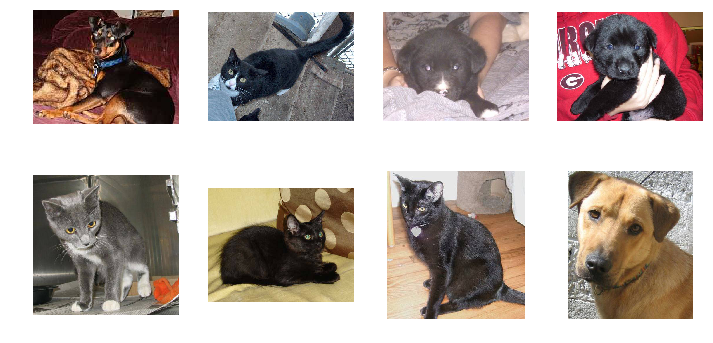

In [101]:
plots([image.load_img(DATA_PATH+'test_small/'+filenames[i]) for i in range(8)], rows=2)

In [102]:
preds[:8]

array([[  1.00000000e+00,   1.56811684e-14],
       [  9.90797698e-01,   9.20228940e-03],
       [  0.00000000e+00,   1.00000000e+00],
       [  0.00000000e+00,   1.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   1.00000000e+00]], dtype=float32)

### En utilisant model.predict_generator()

In [30]:
gen = image.ImageDataGenerator()
test_generator = gen.flow_from_directory(DATA_PATH+'test', target_size=(256, 256),
                                         class_mode='categorical', batch_size=64)

Found 12500 images belonging to 1 classes.


In [29]:
test_generator.filenames

['unknown/9341.jpg',
 'unknown/8274.jpg',
 'unknown/5244.jpg',
 'unknown/1513.jpg',
 'unknown/7131.jpg',
 'unknown/4506.jpg',
 'unknown/9906.jpg',
 'unknown/12198.jpg',
 'unknown/2781.jpg',
 'unknown/7244.jpg',
 'unknown/12448.jpg',
 'unknown/10298.jpg',
 'unknown/9669.jpg',
 'unknown/8184.jpg',
 'unknown/12421.jpg',
 'unknown/7247.jpg',
 'unknown/345.jpg',
 'unknown/6979.jpg',
 'unknown/8855.jpg',
 'unknown/4413.jpg',
 'unknown/4687.jpg',
 'unknown/4097.jpg',
 'unknown/70.jpg',
 'unknown/11066.jpg',
 'unknown/3837.jpg',
 'unknown/3057.jpg',
 'unknown/10984.jpg',
 'unknown/7746.jpg',
 'unknown/4484.jpg',
 'unknown/7024.jpg',
 'unknown/10585.jpg',
 'unknown/388.jpg',
 'unknown/10170.jpg',
 'unknown/4278.jpg',
 'unknown/6449.jpg',
 'unknown/11390.jpg',
 'unknown/4121.jpg',
 'unknown/6777.jpg',
 'unknown/9542.jpg',
 'unknown/8121.jpg',
 'unknown/1036.jpg',
 'unknown/9159.jpg',
 'unknown/9758.jpg',
 'unknown/2670.jpg',
 'unknown/9586.jpg',
 'unknown/11888.jpg',
 'unknown/4776.jpg',
 'unkno

In [32]:
predictions = model.predict_generator(test_generator, int(np.ceil(12500/64)))

ValueError: Error when checking : expected input_1 to have shape (None, 224, 224, 3) but got array with shape (64, 256, 256, 3)

## Soumission des prédictions à Kaggle

In [117]:
test_preds = bcolz.open(RESULTS_PATH+'test_preds.dat')[:]
filenames = bcolz.open(RESULTS_PATH+'test_filenames.dat')[:]

In [118]:
dogs = test_preds[:,1]

In [119]:
#Plafonner les prédictions à 0.95
dogs = dogs.clip(min=0.05, max=0.95)

In [120]:
filenames[0]

'unknown/9341.jpg'

In [121]:
filenames = np.array([int(f[8:f.find('.')]) for f in filenames])

In [122]:
filenames[0]

9341

In [123]:
result = np.stack([filenames, dogs], axis=1)

In [124]:
result[0]

array([  9.34100000e+03,   9.49999988e-01])

In [125]:
np.savetxt("submission_final.csv", result, fmt="%d, %.5f", header="id,label", comments='')

In [127]:
from IPython.display import FileLink
FileLink('submission_final.csv')

/home/pierre/lesson2/from_scratch/submission_final.csv